In [ ]:
#| default_exp datasets
%load_ext autoreload
%autoreload 2

In [ ]:
#| export
import numpy as np
from diffusion_curvature.core import plot_3d
from nbdev.showdoc import *

In this notebook, we'll build various toy datasets and calculate their sectional curvatures.

This will use the Python symbolic computation library, sympy. Note: this library is not required to use the `diffusion_curvature` package. We merely employ it to calculate the curvature and appropriate expressions for rejection sampling.

In [ ]:
import sympy as sym

In [ ]:
theta = sym.Symbol('theta')
phi = sym.Symbol('phi')
R = sym.Symbol("R")
r = sym.Symbol("r")

In [ ]:
f1 = (R + r*sym.cos(theta))*sym.cos(phi)

In [ ]:
sym.diff(f1,theta)

-r*sin(theta)*cos(phi)

In [ ]:
f = sym.Matrix([(R + r*sym.cos(theta))*sym.cos(phi), (R + r*sym.cos(theta))*sym.sin(phi), r*sym.sin(theta)])

In [ ]:
sym.diff(f, theta)

Matrix([
[-r*sin(theta)*cos(phi)],
[-r*sin(phi)*sin(theta)],
[          r*cos(theta)]])

In [ ]:
(sym.diff(f, theta).T  * sym.diff(f, theta))[0]

r**2*sin(phi)**2*sin(theta)**2 + r**2*sin(theta)**2*cos(phi)**2 + r**2*cos(theta)**2

In [ ]:
def rejection_sample_formula(f, variables):
    G = sym.Matrix.zeros(2,2)
    for i, x1 in enumerate(variables):
        for j, x2 in enumerate(variables):
            G[i,j] = (sym.diff(f, x1).T  * sym.diff(f, x2))[0]
    return sym.sqrt(G.det().simplify()).simplify()

In [ ]:
t = rejection_sample_formula(f,[theta, phi])
t

sqrt(r**2*(R + r*cos(theta))**2)

# Torus

The curvature of the torus is given by
$$ S(\theta) = \frac{8 \cos{\theta}}{5 + \cos{\theta}} $$

In [ ]:
#| export
def rejection_sample_for_torus(n, r, R):
    # Rejection sampling torus method [Sampling from a torus (Revolutions)](https://blog.revolutionanalytics.com/2014/02/sampling-from-a-torus.html)
    xvec = np.random.random(n) * 2 * np.pi
    yvec = np.random.random(n) * (1/np.pi)
    fx = (1 + (r/R)*np.cos(xvec)) / (2*np.pi)
    return xvec[yvec < fx]

def torus(n=2000, c=2, a=1, noise=None, seed=None, use_guide_points = False):
    """
    Sample `n` data points on a torus. Modified from [tadasets.shapes — TaDAsets 0.1.0 documentation](https://tadasets.scikit-tda.org/en/latest/_modules/tadasets/shapes.html#torus)
    Uses rejection sampling.

    In addition to the randomly generated points, a few constant points have been added.
    The 0th point is on the outer rim, in a region of high positive curvature. The 1st point is in the inside, in a region of negative curvature, and the 2nd point is on the top, where the curvature should be closer to zero.

    Parameters
    -----------
    n : int
        Number of data points in shape.
    c : float
        Distance from center to center of tube.
    a : float
        Radius of tube.
    ambient : int, default=None
        Embed the torus into a space with ambient dimension equal to `ambient`. The torus is randomly rotated in this high dimensional space.
    seed : int, default=None
        Seed for random state.
    """

    assert a <= c, "That's not a torus"

    np.random.seed(seed)
    theta = rejection_sample_for_torus(n-2, a, c)
    phi = np.random.random((len(theta))) * 2.0 * np.pi

    data = np.zeros((len(theta), 3))
    data[:, 0] = (c + a * np.cos(theta)) * np.cos(phi)
    data[:, 1] = (c + a * np.cos(theta)) * np.sin(phi)
    data[:, 2] = a * np.sin(theta)

    if use_guide_points:
        data = np.vstack([[[0,-c-a,0],[0,c-a,0],[0,c,a]],data])

    if noise:
        data += noise * np.random.randn(*data.shape)

    # compute curvature of sampled torus
    ks = 8*np.cos(theta)/(5 + np.cos(theta))

    return data, ks

In [ ]:
show_doc(torus)

<h4 id="torus" class="doc_header"><code>torus</code><a href="__main__.py#L9" class="source_link" style="float:right">[source]</a></h4>

> <code>torus</code>(**`n`**=*`2000`*, **`c`**=*`2`*, **`a`**=*`1`*, **`noise`**=*`None`*, **`seed`**=*`None`*, **`use_guide_points`**=*`False`*)

Sample `n` data points on a torus. Modified from [tadasets.shapes — TaDAsets 0.1.0 documentation](https://tadasets.scikit-tda.org/en/latest/_modules/tadasets/shapes.html#torus)
Uses rejection sampling.

In addition to the randomly generated points, a few constant points have been added.
The 0th point is on the outer rim, in a region of high positive curvature. The 1st point is in the inside, in a region of negative curvature, and the 2nd point is on the top, where the curvature should be closer to zero.

Parameters
-----------
n : int
    Number of data points in shape.
c : float
    Distance from center to center of tube.
a : float
    Radius of tube.
ambient : int, default=None
    Embed the torus into a space with ambient dimension equal to `ambient`. The torus is randomly rotated in this high dimensional space.
seed : int, default=None
    Seed for random state.

Visualize with the curvature

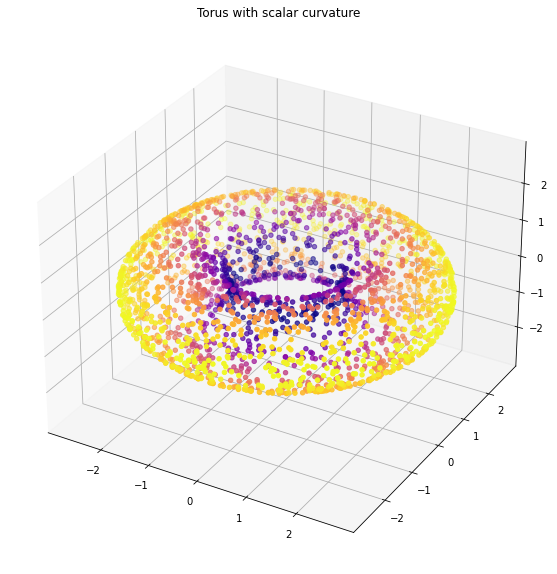

In [ ]:
X,ks = torus(n=5000)
plot_3d(X, ks, title="Torus with scalar curvature")

# One-Sheet Hyperboloid

First, let's determine the rejection sampling formula

In [ ]:
a = sym.Symbol('a')
b = sym.Symbol('b')
theta = sym.Symbol("theta")
u = sym.Symbol('u')
f = sym.Matrix(
    [a*sym.cos(theta)*sym.sqrt(u**2+1),b*sym.sin(theta)*sym.sqrt(u**2+1),u]
)

In [ ]:
variables = [theta, u]
rej = rejection_sample_formula(f, variables)
rej

sqrt(a**2*b**2*u**2 + a**2*u**2*sin(theta)**2 + a**2*sin(theta)**2 - b**2*u**2*sin(theta)**2 + b**2*u**2 - b**2*sin(theta)**2 + b**2)

In [ ]:
#| export
def rejection_sample_for_hyperboloid(n,a,b,c,u_limit):
    theta = np.random.random(n)*2*np.pi
    u = (np.random.random(n)*2 - 1)*u_limit
    fx = np.sqrt(a**2 * b**2 * u**2 + a**2 * u**2 * np.sin(theta)**2 + a**2 * np.sin(theta)**2  - b**2 * u**2 * np.sin(theta)**2 + b**2 * u**2 - b**2 * np.sin(theta)**2 + b**2) 
    yvec = np.random.random(n) * (1/np.max(fx))
    return theta[yvec < fx], u[yvec < fx]

def hyperboloid(n=2000,a=2,b=2,c=1, u_limit = 2, seed=None):
    """Sample roughly n points on a hyperboloid, using rejection sampling.

    Parameters
    ----------
    n : int, optional
        number of points, by default 2000
    a : int, optional
        hyperboloid param1, by default 2
    b : int, optional
        hyperboloid param2, by default 2
    c : int, optional
        stretchiness in z, by default 1
    u_limit : int, optional
        Constrain the free parameter u to [-l,l], by default 2
    seed : int, optional
        For repeatability, seed the randomness, by default None

    Returns
    -------
    The sampled points, and the curvatures of each point
    """

    np.random.seed(seed)
    theta, u = rejection_sample_for_hyperboloid(n,a,b,c,u_limit)
    data = np.zeros((len(theta), 3))
    data[:, 0] = a*np.cos(theta)*np.sqrt(u**2 + 1)
    data[:, 1] = b*np.sin(theta)*np.sqrt(u**2 + 1)
    data[:, 2] = c*u

    # compute curvature of sampled hyperboloid
    ks = -(2/(5*data[:,2]**2 + 1)**2)

    return data, ks

In [ ]:
show_doc

<function nbdev.showdoc.show_doc(elt, doc_string: bool = True, name=None, title_level=None, disp=True, default_cls_level=2, show_all_docments=False, verbose=False)>

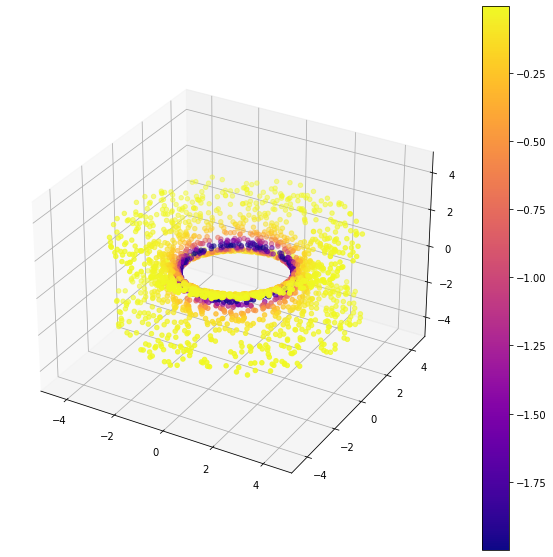

In [ ]:
X, ks = hyperboloid(2000)
plot_3d(X,ks,colorbar=True,use_plotly=False)

# Ellipsoid

In [ ]:
a = sym.Symbol('a')
b = sym.Symbol('b')
c = sym.Symbol('c')
theta = sym.Symbol("theta")
phi = sym.Symbol("phi")
u = sym.Symbol('u')
f = sym.Matrix(
    [a*sym.cos(theta)*sym.sin(phi),b*sym.sin(theta)*sym.sin(phi),c*sym.cos(phi)]
)

In [ ]:
variables = [theta, phi]
rej = rejection_sample_formula(f, variables)
rej

sqrt(-a**2*b**2*sin(phi)**4 + a**2*b**2*sin(phi)**2 + a**2*c**2*sin(phi)**4*sin(theta)**2 - b**2*c**2*sin(phi)**4*sin(theta)**2 + b**2*c**2*sin(phi)**4)

In [ ]:
#| export
def rejection_sample_for_ellipsoid(n,a,b,c):
    theta = np.random.random(n)*2*np.pi
    phi = np.random.random(n)*2*np.pi
    fx = np.sqrt(-a**2 * b**2 * np.sin(phi)**4 + a**2 * b**2 * np.sin(phi)**2 + a**2 * c**2 * np.sin(phi)**4 * np.sin(theta)**2 - b**2 * c**2 * np.sin(phi)**4 * np.sin(theta)**2 + b**2 * c**2 * np.sin(phi)**4)
    yvec = np.random.random(n) * (1/np.max(fx))
    return theta[yvec < fx], phi[yvec < fx]

def ellipsoid(n=2000,a=3,b=2,c=1, seed=None):
    """Sample roughly n points on an ellipsoid, using rejection sampling.

    Parameters
    ----------
    n : int, optional
        number of points, by default 2000
    a : int, optional
        ellipsoid param1, by default 3
    b : int, optional
        ellipsoid param2, by default 2
    c : int, optional
        stretchiness in z, by default 1
    seed : int, optional
        For repeatability, seed the randomness, by default None

    Returns
    -------
    The sampled points, and the curvatures of each point
    """

    np.random.seed(seed)
    theta, phi = rejection_sample_for_ellipsoid(n,a,b,c)
    data = np.zeros((len(theta), 3))
    data[:, 0] = a*np.cos(theta)* np.sin(phi)
    data[:, 1] = b*np.sin(theta)*np.sin(phi)
    data[:, 2] = c*np.cos(phi)

    # compute curvature of sampled torus (gaussian curvature)
    ks = 2* (a**2 * b**2 * c**2) / (a**2 * b**2 * np.cos(phi)**2 + c**2 * (b**2 * np.cos(theta)**2 + a**2 * np.sin(theta)**2)*np.sin(phi)**2)**2
    
    return data, ks

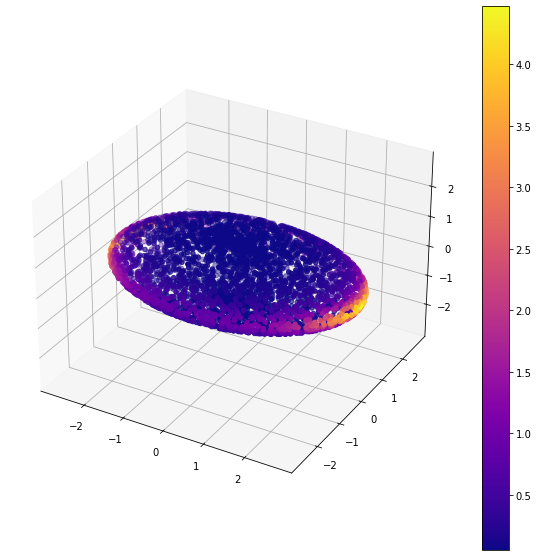

In [ ]:
X, ks = ellipsoid(n=5000)
plot_3d(X,ks,colorbar=True)

# Hypersphere

In [1]:
#| export
def sphere(n, radius=1,noise=0):
    u = np.random.normal(0,1,size=(n))
    v = np.random.normal(0,1,size=(n))
    w = np.random.normal(0,1,size=(n))
    norm = (u*u + v*v + w*w)**(0.5)
    (x,y,z) = (u,v,w)/norm
    X = np.column_stack([x,y,z])
    ks = np.ones(n)*2
    return X, ks

# Random Cube

In [ ]:

def random_cube(n):
    """Return a random cube

    Parameters
    ----------
    n : _type_
        _description_

    Returns
    -------
    _type_
        _description_
    """
    data = np.random.rand(n,3)
    return data

# Saddle Regions
Generate hyperbolic regions as test cases of Laziness curvature.

In [ ]:
a = sym.Symbol('a')
b = sym.Symbol('b')
x = sym.Symbol("x")
y = sym.Symbol("y")
f = sym.Matrix(
    [x,y,a*x**2 + b*y**2]
)

In [ ]:
variables = [x, y]
rej = rejection_sample_formula(f, variables)
rej

sqrt(4*a**2*x**2 + 4*b**2*y**2 + 1)

In [ ]:
#| export
def rejection_sample_for_saddle(n,a,b):
    x = np.random.random(n)*2 - 1 # random values in -1, 1
    y = np.random.random(n)*2 - 1
    fx = np.sqrt(4*a**2*x**2 + 4*b**2*y**2 + 1)
    yvec = np.random.random(n) * (1/np.max(fx))
    return x[yvec < fx], y[yvec < fx]

def paraboloid(n=2000,a=1,b=-1, seed=None, use_guide_points = False):
    """Sample roughly n points on a saddle, using rejection sampling for even density coverage
    Defined by $ax^2 + by^2$. 

    Parameters
    ----------
    n : int, optional
        number of points, by default 2000
    a : int, optional
        ellipsoid param1, by default 1
    b : int, optional
        ellipsoid param2, by default -1
    seed : int, optional
        For repeatability, seed the randomness, by default None

    Returns
    -------
    The sampled points, and the curvatures of each point
    """
    if use_guide_points:
        n = n - 1
    np.random.seed(seed)
    x, y = rejection_sample_for_saddle(n,a,b)
    if use_guide_points:
        x = np.concatenate([[0],x])
        y = np.concatenate([[0],y])
    data = np.zeros((len(x), 3))
    data[:, 0] = x
    data[:, 1] = y
    data[:, 2] = a*x**2 + b*y**2
    # compute curvature of sampled saddle region
    # TODO: Compute gaussian curvature
    # TODO: Currently assuming that b is negative (hyperbolic paraboloid)
    ap = np.sqrt(1/a) 
    bp = b/np.abs(b) * np.sqrt(1/np.abs(b))
    ks = -(4*a**6 * b**6)/(a**4*b**4 + 4*b**4*x**2+4*a**4*y**2)**2
    
    return data, ks

In [ ]:
X, ks = paraboloid(n=10000, a = 1, b = -1,use_guide_points=True)

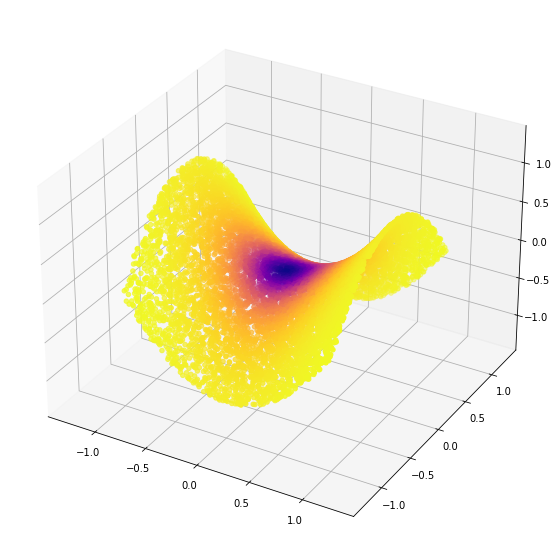

In [ ]:
plot_3d(X,ks)

In [ ]:
x = np.zeros(10)

In [ ]:
np.concatenate([[0],x])

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
np.savetxt("datasets/hyperboloid.txt",X)

In [ ]:
Y = np.loadtxt("datasets/hyperboloid.txt",dtype=float)

In [ ]:
Y

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.22442539, -0.77392569, -0.54859421],
       [ 0.26465483, -0.32006763, -0.03240111],
       ...,
       [ 0.25556159,  0.10433996,  0.0544249 ],
       [ 0.08955998,  0.38837172, -0.1428116 ],
       [-0.07217504,  0.02386817,  0.00463955]])